In [55]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import (
    ssdlite320_mobilenet_v3_large,
    SSDLite320_MobileNet_V3_Large_Weights,
    ssd300_vgg16,
    SSD300_VGG16_Weights
)
import pathlib
from pathlib import Path

import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

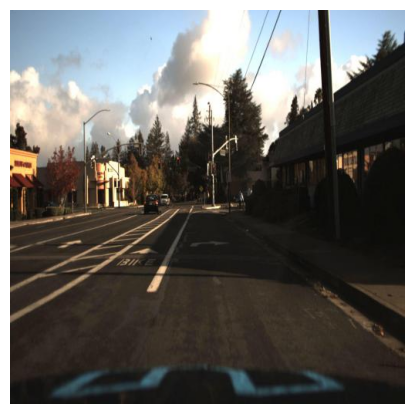

In [57]:
train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=None, file_pct=1)

train_data.show_with_box(index=53, color='r', label=False, lw=0)

In [58]:
len(train_data)

19863

In [64]:
np.random.randint(0, len(train_data), size=1)[0]

np.int32(14669)

In [ ]:
train_data[17][1]['boxes']

BoundingBoxes([[205., 251., 209., 257.],
               [222., 251., 228., 258.],
               [178., 250., 186., 261.],
               [  1., 227.,  84., 452.],
               [  8., 211.,  94., 286.],
               [189., 247., 200., 264.],
               [423., 233., 447., 253.]], format=BoundingBoxFormat.XYXY, canvas_size=(512, 512))

In [3]:
all_paths = list(pathlib.Path(train_path).glob("*.jpg"))

In [4]:
np.random.choice(all_paths, size=1)[0]

WindowsPath('D:/Udacity_car_data/data/train/1478901435841308307_jpg.rf.21668d958c7ef36b1f739540bfec4440.jpg')

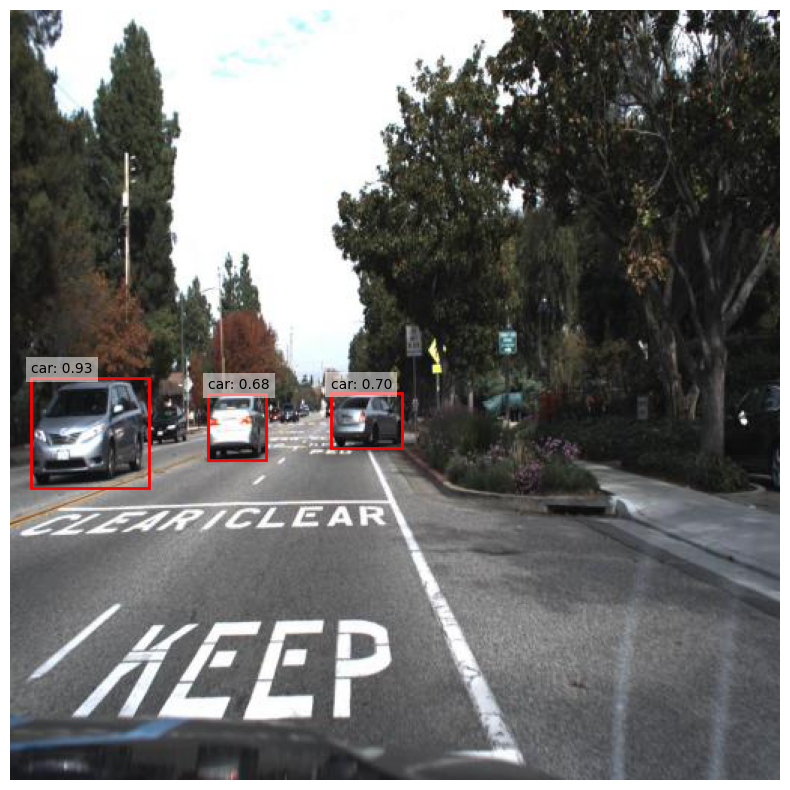

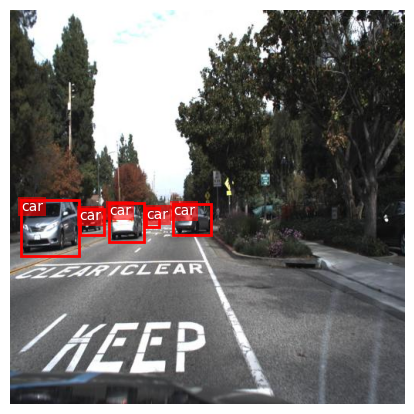

In [85]:
# 1) Device and weights
# device = torch.device("cpu")   # or "cuda" if available
weights = SSD300_VGG16_Weights.DEFAULT
categories = weights.meta["categories"]  # list of class names

# 2) Model
model = ssd300_vgg16(weights=weights).to(device).eval()

# 3) Load image
rand_idx = np.random.randint(0, len(train_data), size=1)[0]
img = train_data.load_image(rand_idx)
# img_path = np.random.choice(all_paths, size=1)[0] # r"C:\self-driving-car\data\train_one_obj\1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg" #"your_image.jpg"
# img = Image.open(img_path).convert("RGB")          # keep original for plotting

# 4) Preprocess
preprocess = weights.transforms()
img_t = preprocess(img)                            # Tensor [C, 320, 320]
batch = img_t.unsqueeze(0).to(device)              # [1, C, H, W]

# 5) Inference
with torch.no_grad():
    out = model(batch)[0]                          # dict with 'boxes','labels','scores'

# 6) Pull results to CPU numpy
boxes  = out["boxes"].cpu().numpy()                # shape [N,4], xyxy in *resized* coords
labels = out["labels"].cpu().numpy()               # shape [N]
scores = out["scores"].cpu().numpy()               # shape [N]

# 7) Confidence filtering
thr = 0.25
keep = scores >= thr
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
names = [categories[i] for i in labels]

# 8) (Optional) Map boxes back to original image size
H_resized, W_resized = img_t.shape[1], img_t.shape[2]  # 320, 320
H_orig,    W_orig    = 512, 512 #img.height, img.width
sx = W_orig / W_resized
sy = H_orig / H_resized
boxes_orig = boxes.copy()
boxes_orig[:, [0,2]] *= sx
boxes_orig[:, [1,3]] *= sy

# 9) (Optional) Visualize
def draw(img_pil, boxes_xyxy, labels_txt, scores_arr):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_pil)
    for (x1, y1, x2, y2), lbl, sc in zip(boxes_xyxy, labels_txt, scores_arr):
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, linewidth=2, edgecolor='r'))
        ax.text(x1, y1-3, f"{lbl}: {sc:.2f}", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
    ax.axis("off")
    plt.show()

draw(img, boxes_orig, names, scores)

train_data.show_with_box(index=rand_idx, color='r', label=True)

In [76]:
img_path = np.random.choice(all_paths, size=1)[0]
img = Image.open(img_path).convert("RGB")

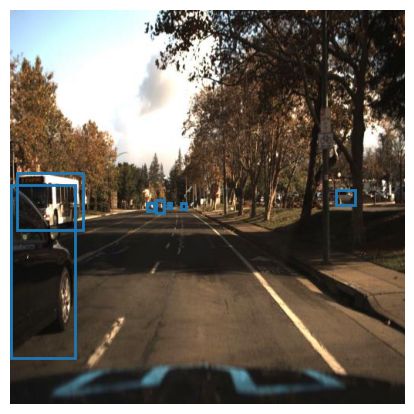

In [83]:
train_data.show_with_box(17)

In [26]:
test = model(batch)

In [40]:
test[0]['labels'].shape

torch.Size([300])

In [54]:
model.named_modules

<bound method Module.named_modules of SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad